# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.75KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

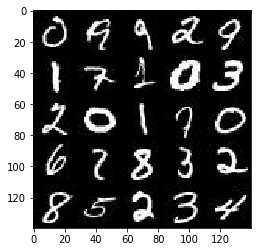

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

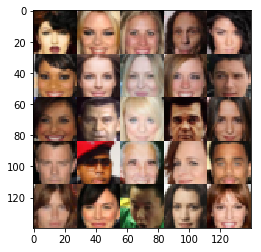

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name="lr")
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.8
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xout_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.8
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                        activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                        activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                            activation=None)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1

    # Get the loss
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    # display params
    steps = 0
    show_every = 100
    print_every = 10
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)   
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


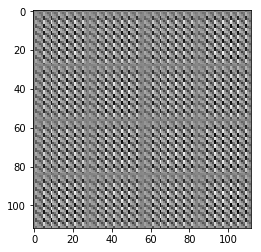

Epoch 1/2... Discriminator Loss: 0.0198... Generator Loss: 21.9732
Epoch 1/2... Discriminator Loss: 0.0513... Generator Loss: 6.8011
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 19.2960
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 12.5202
Epoch 1/2... Discriminator Loss: 0.0186... Generator Loss: 5.2243
Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.5078
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.1440
Epoch 1/2... Discriminator Loss: 0.0026... Generator Loss: 7.6255
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 15.5483
Epoch 1/2... Discriminator Loss: 0.0366... Generator Loss: 7.7798


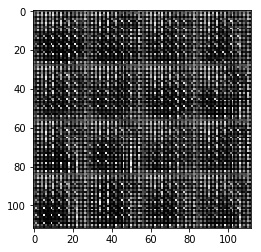

Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.6017
Epoch 1/2... Discriminator Loss: 0.0026... Generator Loss: 7.0686
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 7.4760
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.2828
Epoch 1/2... Discriminator Loss: 4.6890... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 0.2909... Generator Loss: 3.3825
Epoch 1/2... Discriminator Loss: 0.1197... Generator Loss: 3.3174
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 3.9839
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 3.3167
Epoch 1/2... Discriminator Loss: 1.7202... Generator Loss: 3.3828


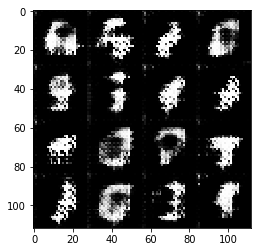

Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 3.1274
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 2.0602
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.3343
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 1.4195
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 1.4345
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.6524... Generator Loss: 0.4804


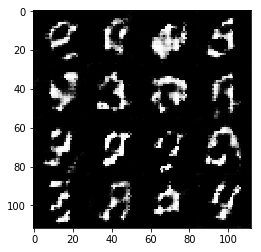

Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.7959... Generator Loss: 0.2742
Epoch 1/2... Discriminator Loss: 2.0222... Generator Loss: 0.2151
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 0.9935
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.4391
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.3059
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7167


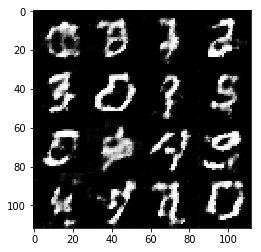

Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.6082
Epoch 1/2... Discriminator Loss: 1.5611... Generator Loss: 1.8086
Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 1.5137
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 0.6423
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.8203
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.3291


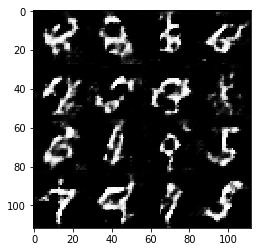

Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 1.4325
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.6547
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.3487
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.7055


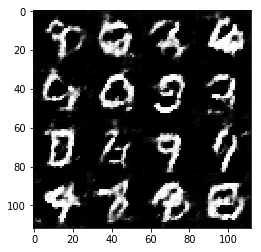

Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 2.1565
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.1703
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 1.6555... Generator Loss: 0.3180
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.5178


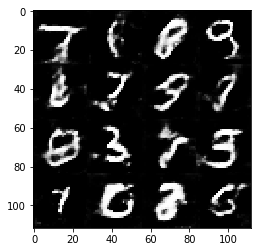

Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.4614
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.2608
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 1.0813


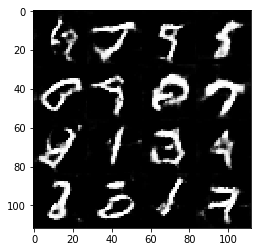

Epoch 1/2... Discriminator Loss: 1.9747... Generator Loss: 0.2243
Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.6613
Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 0.3686
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.2417


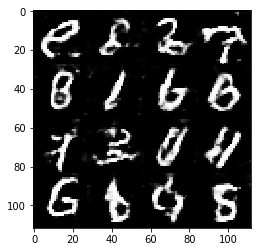

Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 2.2372
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.3491
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.0993
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.5755... Generator Loss: 0.2981
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 1.9988


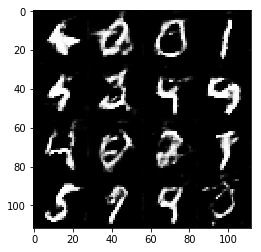

Epoch 2/2... Discriminator Loss: 1.5429... Generator Loss: 0.3397
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.7167
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.5798... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.7871
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.2774
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.4989


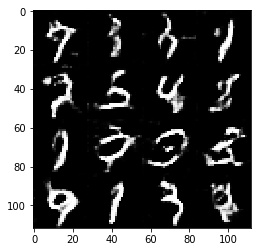

Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 2.1673
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.3837
Epoch 2/2... Discriminator Loss: 0.6109... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 2.7648... Generator Loss: 0.1072
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.6517


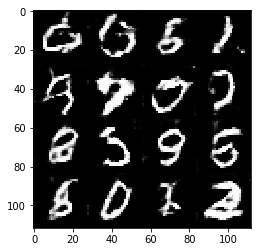

Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.7025... Generator Loss: 0.3482
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 4.0544
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 1.5522
Epoch 2/2... Discriminator Loss: 1.8798... Generator Loss: 4.2928
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.6939


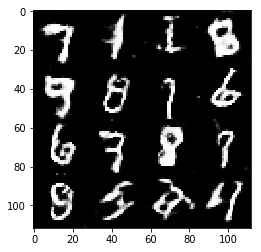

Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 2.4446
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.6529
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 1.4509
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.4075
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.3444


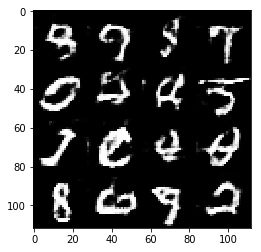

Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.1910
Epoch 2/2... Discriminator Loss: 0.3013... Generator Loss: 1.9232
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 1.8117
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.8223


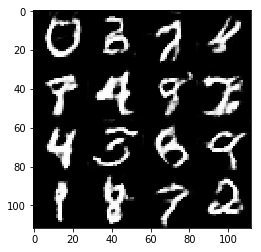

Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 2.0770... Generator Loss: 0.2744
Epoch 2/2... Discriminator Loss: 0.4862... Generator Loss: 1.6477
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 0.4140... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 0.2266... Generator Loss: 2.3764


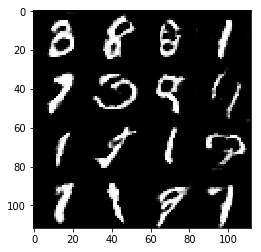

Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.1799
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 1.3748
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.3866
Epoch 2/2... Discriminator Loss: 0.1610... Generator Loss: 2.6432
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.3064
Epoch 2/2... Discriminator Loss: 7.4741... Generator Loss: 0.0047
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 2.0675
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.5311


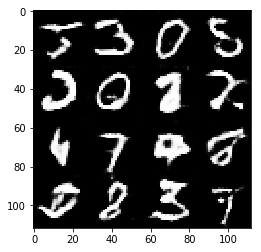

Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.8875
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 2.7371
Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.6897... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 1.4394


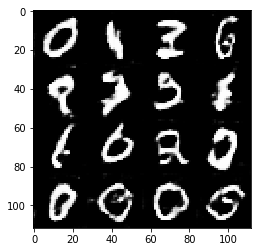

Epoch 2/2... Discriminator Loss: 0.3072... Generator Loss: 1.8893
Epoch 2/2... Discriminator Loss: 0.4607... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 2.3151... Generator Loss: 0.2515
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.6818
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.7481


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


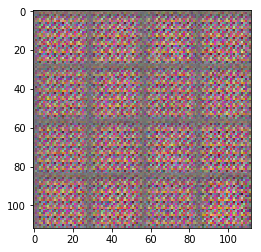

Epoch 1/1... Discriminator Loss: 4.3764... Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 2.2351
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.3160
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 4.0699
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 3.4193
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.8729
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 3.1315
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.3911


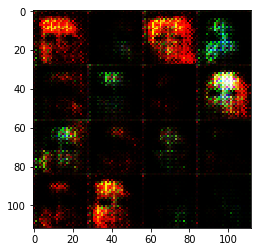

Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.7693
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 3.3996
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.9246
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.5573
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 4.3127
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 4.3274
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.4564
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.5277
Epoch 1/1... Discriminator Loss: 3.1085... Generator Loss: 4.1375
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 2.0401


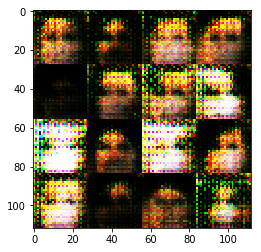

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 3.2053
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 3.8942
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 3.2799
Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 2.2141
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 2.2115
Epoch 1/1... Discriminator Loss: 1.7568... Generator Loss: 0.3910


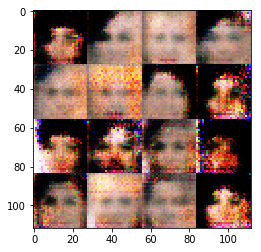

Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 3.0971... Generator Loss: 5.5995
Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 2.2520... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8197


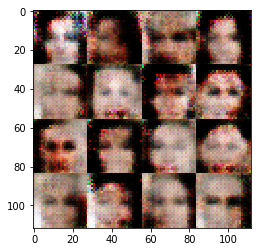

Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.9767... Generator Loss: 2.8101
Epoch 1/1... Discriminator Loss: 2.1302... Generator Loss: 0.2164
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.8016... Generator Loss: 2.5469
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.4157


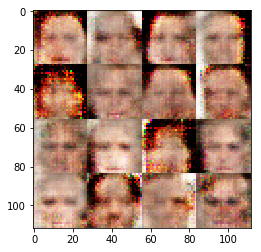

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 2.0206
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 2.6870


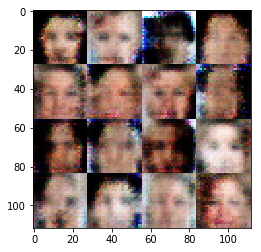

Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 2.3010
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.0990


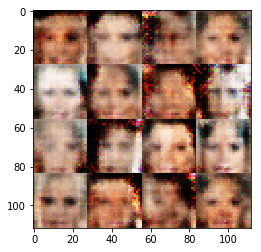

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 2.3016
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8960


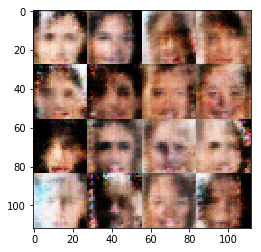

Epoch 1/1... Discriminator Loss: 1.8480... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 2.0060... Generator Loss: 2.2415
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7958


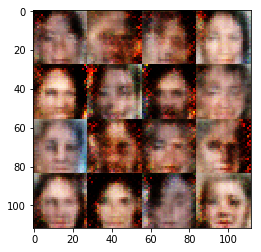

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 1.8060
Epoch 1/1... Discriminator Loss: 2.1998... Generator Loss: 2.5182
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.0119


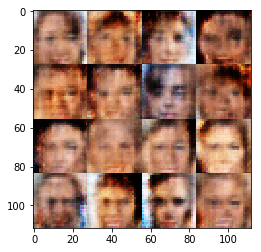

Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.2616


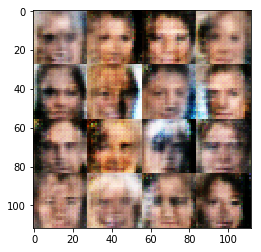

Epoch 1/1... Discriminator Loss: 3.3020... Generator Loss: 4.0651
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 2.4264... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.5640


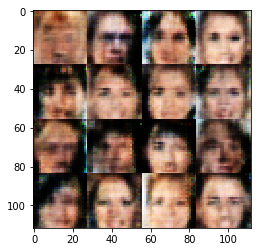

Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 2.5489
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.2899


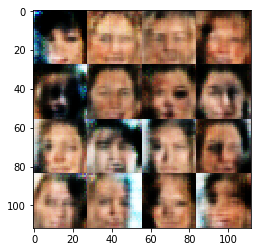

Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.8284
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7050


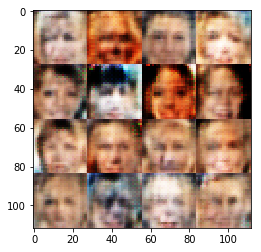

Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.0688


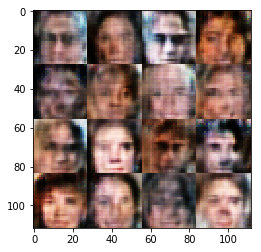

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.7098
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.1382


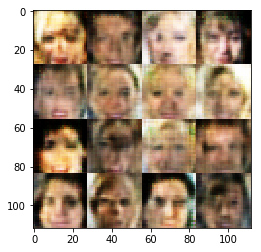

Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.8121... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6915


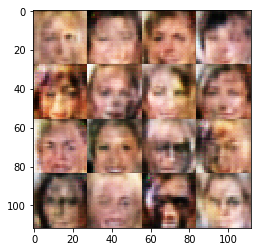

Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 2.1914
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6169


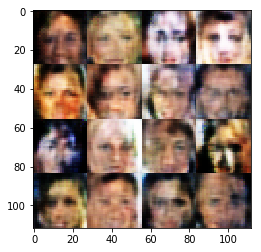

Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.9143... Generator Loss: 2.8393
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 2.7444... Generator Loss: 0.1521
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 2.0142


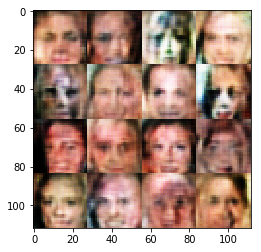

Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 2.2702
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.9085... Generator Loss: 2.3302
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.6369
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 2.6611
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.2287


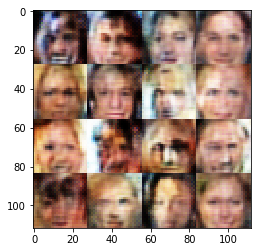

Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 2.0062
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 1.9044
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 2.0130
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 2.1545
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 1.9068
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7665


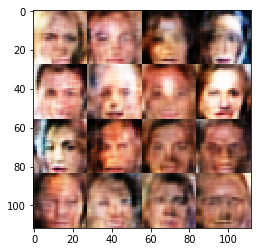

Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 3.1281
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.2650
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.3575


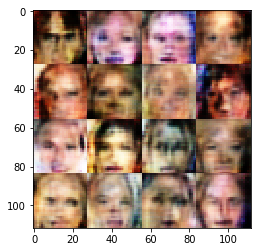

Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.0486


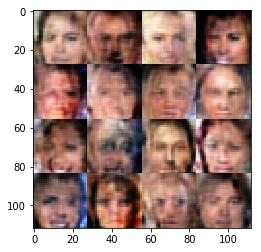

Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.5109


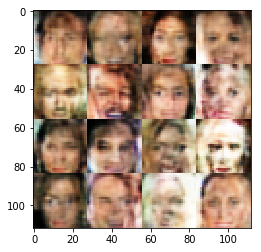

Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 2.3104... Generator Loss: 0.2287
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 2.5821
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6692


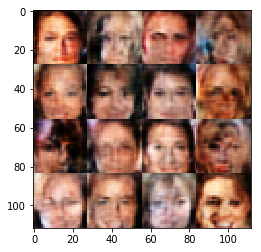

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.0547
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.8194
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.4739


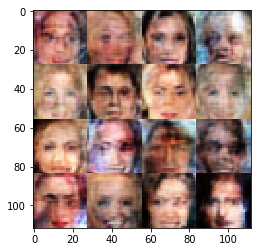

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.6914
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.9765
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 2.0671
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 3.1626
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 3.2148


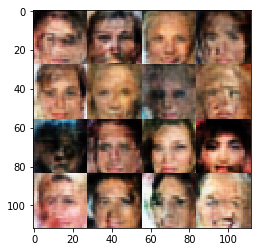

Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 3.5121
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 3.0423
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 2.8874
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.0892
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 2.9780


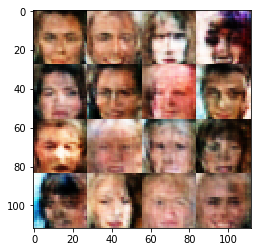

Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.6407
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.9222
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 2.6160
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 2.9244
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 3.2668
Epoch 1/1... Discriminator Loss: 2.1989... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 2.0260


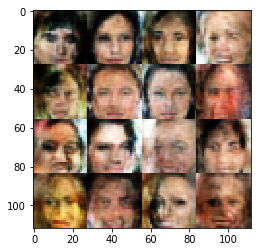

Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 2.3976
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.8690
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.9933
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 3.3582
Epoch 1/1... Discriminator Loss: 3.2686... Generator Loss: 4.5811
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.4205
Epoch 1/1... Discriminator Loss: 1.9224... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.8873
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.7711


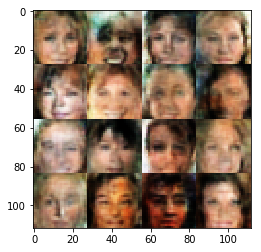

Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 3.0858
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.7898
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.8321
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 4.3998
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 2.1933


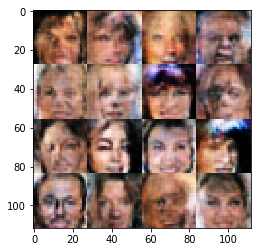

Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.6136


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.